In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from abc import ABC, abstractmethod

# Multi-Armed Bandit related Code

First, let's define Arms as a generic class in Python. This class will declare several methods:

In [2]:
class Arm(ABC):
    def __init__(self):
        self.total_reward = 0.0
        self.pull_count = 0

    @abstractmethod
    def pull(self):
        """
        Simulate pulling the arm. Should return a reward.
        """
        pass

    @abstractmethod
    def get_expected_value(self):
        """
        Return the theoretical expected value of this arm (if known).
        """
        pass

    def get_empirical_mean(self):
        """
        Return the average reward received so far (empirical mean).
        """
        if self.pull_count == 0:
            return 0.0
        return self.total_reward / self.pull_count

    def get_pull_count(self):
        """
        Return the number of times this arm has been pulled.
        """
        return self.pull_count

    def update_stats(self, reward):
        """
        Internal method to update stats after a pull.
        """
        self.total_reward += reward
        self.pull_count += 1

    def reset(self):
        """
        Reset the total reward and pull count to start fresh.
        """
        self.total_reward = 0.0
        self.pull_count = 0

Now, let's implement two different arms: one with a normal distribution and another with a discrete probability distribution and varying reward values.

In [3]:
# Normal Distribution Arm
class NormalArm(Arm):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def pull(self):
        reward = np.random.normal(self.mean, self.std)
        self.update_stats(reward)
        return reward

    def get_expected_value(self):
        return self.mean

# Discrete Distribution Arm
class DiscreteArm(Arm):
    def __init__(self, rewards, probabilities):
        super().__init__()
        assert len(rewards) == len(probabilities), "Rewards and probabilities must be the same length"
        assert abs(sum(probabilities) - 1.0) < 1e-6, "Probabilities must sum to 1"
        self.rewards = rewards
        self.probabilities = probabilities

    def pull(self):
        reward = np.random.choice(self.rewards, p=self.probabilities)
        self.update_stats(reward)
        return reward

    def get_expected_value(self):
        return sum(r * p for r, p in zip(self.rewards, self.probabilities))

Now, lets define the Bandit class. It will have a list of Arms and other functions required to run the code.

In [4]:
class Bandit:
    def __init__(self, arms, selection_algorithm):
        self.arms = arms
        self.selection_algorithm = selection_algorithm
        self.total_reward = 0.0
        self.pull_history = []

    def select_arm(self, step=None):
        # Try passing step if the algorithm expects it
        if step is not None:
            return self.selection_algorithm.select_arm(self.arms, step)
        return self.selection_algorithm.select_arm(self.arms)

    def pull_arm(self, step=None):
        arm_index = self.select_arm(step)
        reward = self.arms[arm_index].pull()
        self.total_reward += reward
        self.pull_history.append((arm_index, reward))
        return arm_index, reward

    def reset(self):
        self.total_reward = 0.0
        self.pull_history.clear()
        for arm in self.arms:
            arm.reset()

    def get_total_reward(self):
        return self.total_reward

    def get_arm_stats(self):
        return [
            {
                'empirical_mean': arm.get_empirical_mean(),
                'pull_count': arm.get_pull_count()
            }
            for arm in self.arms
        ]

    def run(self, rounds, optimal_expected_value=None):
        rewards = []
        regret = []
        cumulative_reward = 0.0
        cumulative_regret = 0.0

        for t in range(1, rounds + 1):
            _, reward = self.pull_arm(step=t)
            cumulative_reward += reward
            rewards.append(cumulative_reward / t)
            if optimal_expected_value is not None:
                cumulative_regret += (optimal_expected_value - reward)
                regret.append(cumulative_regret)
        return rewards, regret

The Bandit class above contains a selection algorithm. To support this, let’s define an interface that specifies how to select an arm. For now, we will implement the following selection strategies: random selection, epsilon-greedy selection, and UCB selection.

In [5]:
class SelectionAlgorithm(ABC):
    @abstractmethod
    def select_arm(self, arms):
        pass

class RandomSelection(SelectionAlgorithm):
    def select_arm(self, arms,step):
        return random.randint(0, len(arms) - 1)

class EpsilonGreedySelection(SelectionAlgorithm):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def select_arm(self, arms, step):
        if random.random() < self.epsilon:
            # Explore
            return random.randint(0, len(arms) - 1)
        else:
            # Exploit: choose arm with highest empirical mean
            means = [arm.get_empirical_mean() for arm in arms]
            max_mean = max(means)
            # In case of tie, randomly pick among the best
            best_arms = [i for i, mean in enumerate(means) if mean == max_mean]
            return random.choice(best_arms)

class UCBSelection(SelectionAlgorithm):
    def __init__(self, c=2):
        self.c = c  # exploration parameter

    def select_arm(self, arms, step: int) -> int:
        ucb_values = []
        for arm in arms:
            pulls = arm.get_pull_count()
            if pulls == 0:
                return arms.index(arm)  # explore untried arm
            mean = arm.get_empirical_mean()
            bonus = self.c * math.sqrt(math.log(step + 1) / pulls)
            ucb_values.append(mean + bonus)
        return ucb_values.index(max(ucb_values))




Now lets run the code with multiple cases.

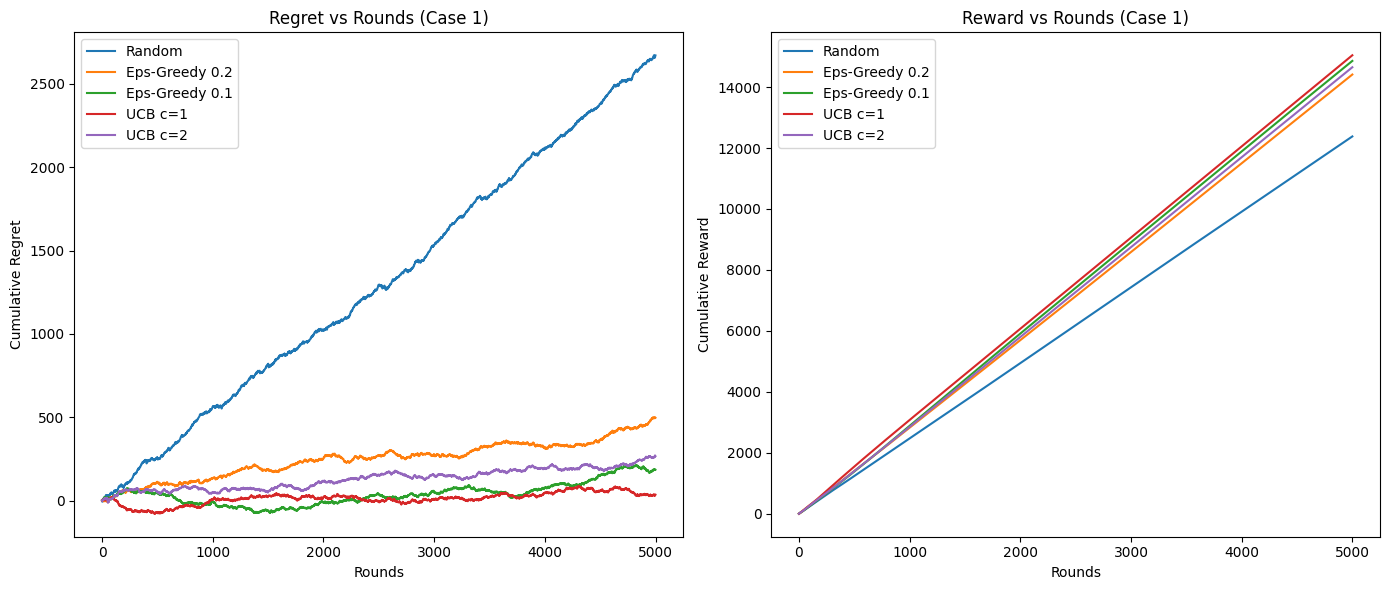

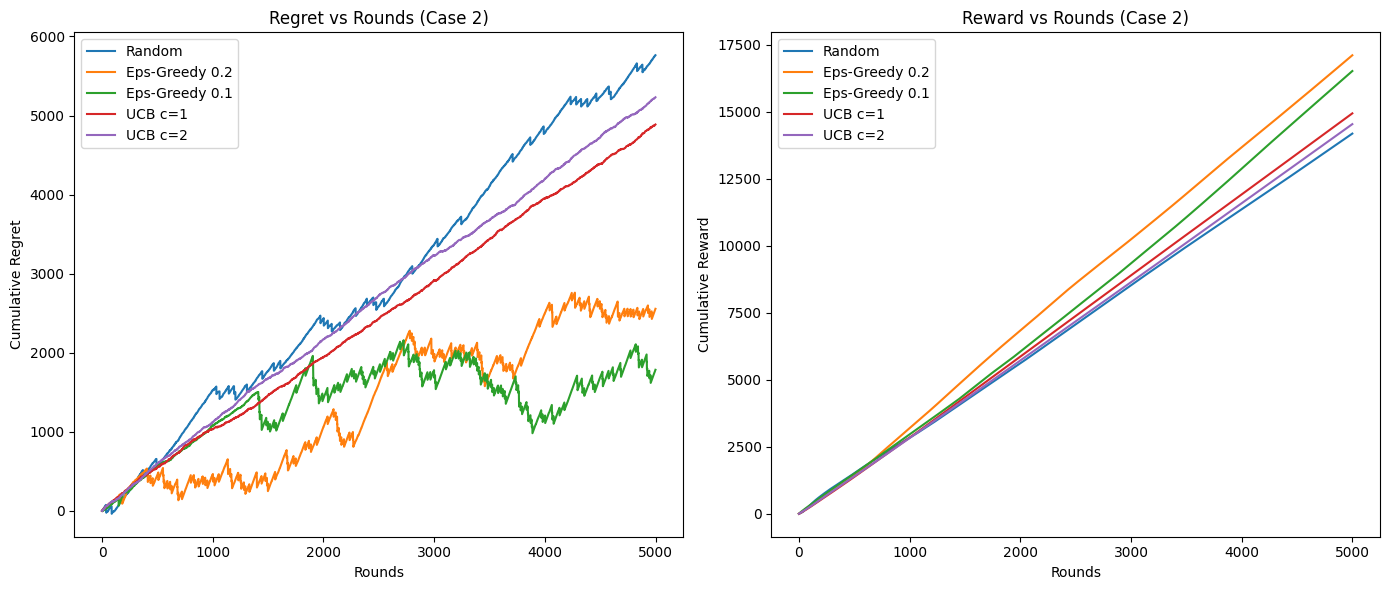

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- Helper to create arms ---
def get_arms(case=1):
    arms = [
        lambda: NormalArm(mean=2.5, std=1.0),
        lambda: NormalArm(mean=2.0, std=0.5),
        lambda: NormalArm(mean=3.0, std=1.5),
        lambda: DiscreteArm(rewards=[2, 4], probabilities=[0.6, 0.4]),
    ]
    if case == 1:
        arms.append(lambda: DiscreteArm(rewards=[10, 0], probabilities=[0.2, 0.8]))
    elif case == 2:
        arms.append(lambda: DiscreteArm(rewards=[100, 0], probabilities=[0.04, 0.96]))
    return arms

# --- Run experiment ---
def run_experiment(arms_setup, strategies, rounds):
    results = {}
    optimal_value = max(arm().get_expected_value() for arm in arms_setup)

    for name, strategy in strategies.items():
        bandit = Bandit(arms=[arm() for arm in arms_setup], selection_algorithm=strategy)
        rewards, regret = bandit.run(rounds, optimal_value)
        results[name] = {'rewards': rewards, 'regret': regret}
    return results

# --- Plotting ---
def plot_results(results, rounds, title_suffix=""):
    x = np.arange(rounds)
    plt.figure(figsize=(14, 6))

    # Regret plot
    plt.subplot(1, 2, 1)
    for name, data in results.items():
        plt.plot(x, data['regret'], label=name)
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Regret')
    plt.title(f'Regret vs Rounds {title_suffix}')
    plt.legend()

    # Reward plot
    plt.subplot(1, 2, 2)
    for name, data in results.items():
        plt.plot(x, np.cumsum(data['rewards']), label=name)
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Reward vs Rounds {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Define strategies ---
def get_strategies():
    return {
        "Random": RandomSelection(),
        "Eps-Greedy 0.2": EpsilonGreedySelection(epsilon=0.2),
        "Eps-Greedy 0.1": EpsilonGreedySelection(epsilon=0.1),
        "UCB c=1": UCBSelection(c=1),
        "UCB c=2": UCBSelection(c=2),
    }

# --- Run Case 1 ---
rounds = 5000
arms_case1 = get_arms(case=1)
strategies = get_strategies()
results_case1 = run_experiment(arms_case1, strategies, rounds)
plot_results(results_case1, rounds, title_suffix="(Case 1)")

# --- Run Case 2 ---
arms_case2 = get_arms(case=2)
results_case2 = run_experiment(arms_case2, strategies, rounds)
plot_results(results_case2, rounds, title_suffix="(Case 2)")

In [7]:
def run_multiple_experiments(arms_setup_fn, strategies, rounds, num_trials):
    all_rewards = {name: [] for name in strategies}
    all_regrets = {name: [] for name in strategies}

    for trial in range(num_trials):
        # Instantiate arms
        arms = [arm() for arm in arms_setup_fn()]
        # Compute optimal expected value for regret calculation
        optimal_value = max([arm.get_expected_value() for arm in arms])

        for name, strategy_class in strategies.items():
            strategy = strategy_class()  # Instantiate strategy
            # Create fresh arms for each strategy in each trial
            arms_instance = [arm() for arm in arms_setup_fn()]
            bandit = Bandit(arms=arms_instance, selection_algorithm=strategy)
            rewards, regrets = bandit.run(rounds, optimal_expected_value=optimal_value)
            all_rewards[name].append(rewards)
            all_regrets[name].append(regrets)

    # Average over all trials
    avg_rewards = {
        name: np.mean(all_rewards[name], axis=0) for name in strategies
    }
    avg_regrets = {
        name: np.mean(all_regrets[name], axis=0) for name in strategies
    }

    return {
        'avg_rewards': avg_rewards,
        'avg_regrets': avg_regrets
    }

In [8]:
rounds = 500
num_trials = 100
arms_setup_fn = lambda: [
    lambda: NormalArm(mean=2.5, std=1.0),
    lambda: NormalArm(mean=2.0, std=0.5),
    lambda: NormalArm(mean=3.0, std=1.5),
    lambda: DiscreteArm(rewards=[2, 4], probabilities=[0.6, 0.4]),
    lambda: DiscreteArm(rewards=[10, 0], probabilities=[0.2, 0.8])
]

strategies = {
    "Random": RandomSelection,
    "Eps_0.1": lambda: EpsilonGreedySelection(epsilon=0.1),
    "Eps_0.2": lambda: EpsilonGreedySelection(epsilon=0.2),
    "UCB_c2": lambda: UCBSelection(c=2)
}

results = run_multiple_experiments(arms_setup_fn, strategies, rounds, num_trials)

In [9]:
import matplotlib.pyplot as plt

def plot_results(results, rounds):
    avg_rewards = results['avg_rewards']
    avg_regrets = results['avg_regrets']
    x = list(range(1, rounds + 1))

    # Plot average rewards
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, reward in avg_rewards.items():
        plt.plot(x, reward, label=name)
    plt.title("Average Reward per Round")
    plt.xlabel("Round")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)

    # Plot average regrets
    plt.subplot(1, 2, 2)
    for name, regret in avg_regrets.items():
        plt.plot(x, regret, label=name)
    plt.title("Average Regret per Round")
    plt.xlabel("Round")
    plt.ylabel("Average Regret")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

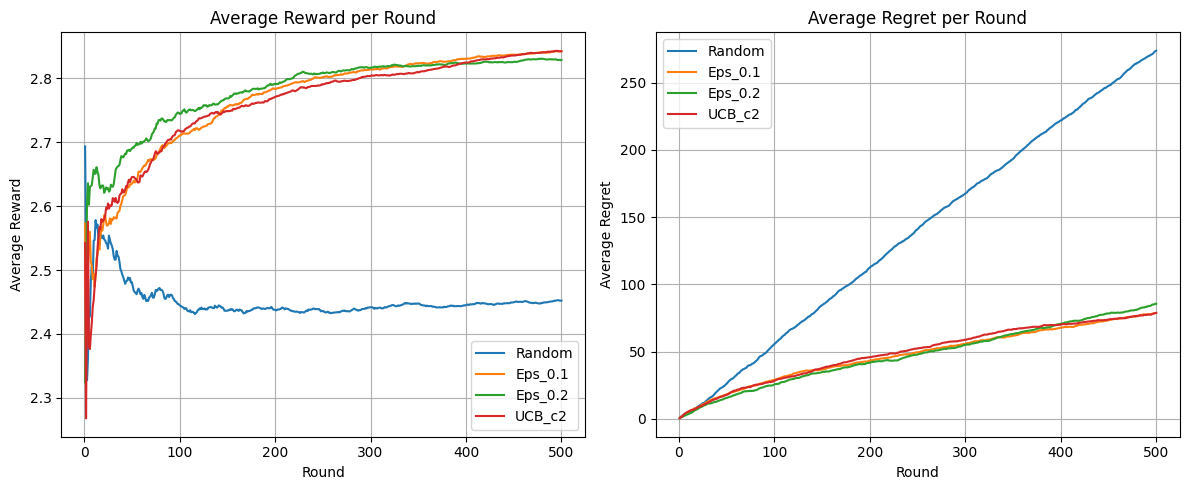

In [10]:
results = run_multiple_experiments(arms_setup_fn, strategies, rounds, num_trials)
plot_results(results, rounds)

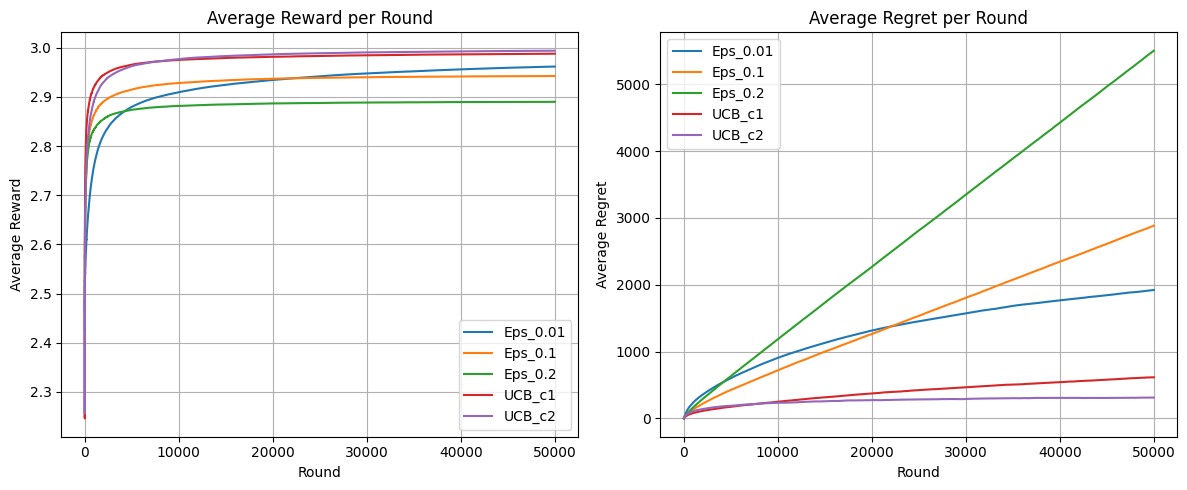

In [13]:
rounds = 50000
num_trials = 1000
arms_setup_fn = lambda: [
    lambda: NormalArm(mean=2.5, std=1.0),
    lambda: NormalArm(mean=2.0, std=0.5),
    lambda: NormalArm(mean=3.0, std=1.5),
    lambda: DiscreteArm(rewards=[2, 4], probabilities=[0.6, 0.4]),
    lambda: DiscreteArm(rewards=[10, 0], probabilities=[0.2, 0.8])
]

strategies = {
    "Eps_0.01": lambda: EpsilonGreedySelection(epsilon=0.01),
    "Eps_0.1": lambda: EpsilonGreedySelection(epsilon=0.1),
    "Eps_0.2": lambda: EpsilonGreedySelection(epsilon=0.2),
    "UCB_c1": lambda: UCBSelection(c=1),
    "UCB_c2": lambda: UCBSelection(c=2)
}


results = run_multiple_experiments(arms_setup_fn, strategies, rounds, num_trials)
plot_results(results, rounds)

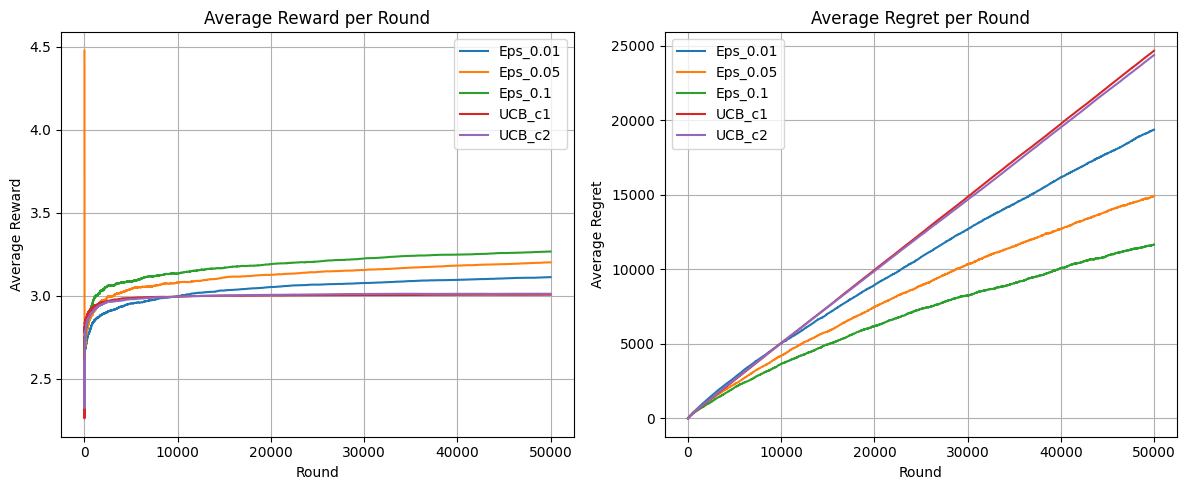

In [14]:
rounds = 50000
num_trials = 200
arms_setup_fn = lambda: [
    lambda: NormalArm(mean=2.5, std=1.0),
    lambda: NormalArm(mean=2.0, std=0.5),
    lambda: NormalArm(mean=3.0, std=1.5),
    lambda: DiscreteArm(rewards=[2, 4], probabilities=[0.6, 0.4]),
    lambda: DiscreteArm(rewards=[100, 0], probabilities=[0.035, 0.965])
]

strategies = {
    "Eps_0.01": lambda: EpsilonGreedySelection(epsilon=0.01),
    "Eps_0.05": lambda: EpsilonGreedySelection(epsilon=0.05),
    "Eps_0.1": lambda: EpsilonGreedySelection(epsilon=0.1),
    "UCB_c1": lambda: UCBSelection(c=1),
    "UCB_c2": lambda: UCBSelection(c=2)
}


results = run_multiple_experiments(arms_setup_fn, strategies, rounds, num_trials)
plot_results(results, rounds)